In [2]:
import time
import math
import os
import random

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skimage
from scipy import ndimage as ndi
from skimage.feature import hog, greycomatrix, greycoprops
from skimage.color import rgb2gray
from skimage.filters import gabor_kernel
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
import cv2
from osgeo import gdal
from osgeo import osr
import numpy as np

In [20]:
import time
import math
import os
import random

from sklearn.cluster import KMeans
import skimage
from scipy import ndimage as ndi
import numpy as np
from osgeo import gdal
from osgeo import osr
from skimage.color import rgb2gray
from skimage.filters import gabor_kernel

from ..utilities.io import *

def global_convolve_filters(image_arr, filterbank):
    """
    returns the mean and variance of the gabor responses for the entire image_arr.
    acts as a 'global' feature extractor
    """
    count = 0
    feats = np.zeros(shape(len(filterbank*2),), dtype=np.double)
    for kernel in enumerate(filterbank):
        filtered = ndi.convolve(image_arr, kernel, mode='wrap')
        feats[count] = filtered.mean()
        count+=1
        feats[count] = filtered.var()
        count+=1
    return feats

def create_filter_bank(thetas, sigmas, frequencies):
    filterbank = []
    for theta in thetas:
        theta = theta / float(len(thetas)) * math.pi
        for sigma in sigmas:
            for frequency in frequencies:
                kernel = np.real(gabor_kernel(frequency, theta=theta,
                                              sigma_x=sigma, sigma_y=sigma))
                filterbank.append(kernel)
    return filterbank

def local_convolve_filters(image_name, filterbank, output_dir):
    # for BOVW feature descriptors
    ds = gdal.Open(image_name)
    image = ds.ReadAsArray()
    geotran = ds.GetGeoTransform()
    rows = ds.RasterYSize
    cols = ds.RasterXSize
    ds = None
    
    out_srs = osr.SpatialReference()
    out_srs.ImportFromEPSG(4326)
    out_srs_wkt = out_srs.ExportToWkt()
    
    image = np.moveaxis(image, 0, -1)
    image = skimage.img_as_ubyte(rgb2gray(image))
    
    out_image = np.zeros(shape=(len(filterbank), image.shape[0], image.shape[1]), dtype=np.double)
    for k, kernel in enumerate(filterbank):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        out_image[k] = filtered
    
    output = os.path.join(outdir, os.path.basename(image_name)[-4:] + "_gabor_feat_vecs.tif")
    write_geotiff(output, out_image, out_geotran, out_srs_wkt)
    return out_image

def get_rand_gabor_feats(image_dir, sample_num=100000):
    gabor_feats = []
    image_files = [n for n in os.listdir(image_dir) if n[-19:] == "gabor_feat_vecs.tif"]
    rand_file_idx = [random.randint(0, len(image_files)-1) for n in range(sample_num)]
    rand_file_idx.sort()
    count = 0
    cur_file = None
    while len(gabor_feats) < sample_num:
        if cur_file != image_files[rand_file_idx[count]]:
            cur_file = image_files[rand_file_idx[count]]
            ds = gdal.Open(cur_file)
            gabor_im = ds.ReadAsArray()
        rand_gabor_feat = get_rand_image_feat(gabor_im)
        gabor_feats.append(rand_gabor_feat) # read a random sift feature from the array and append only its description to keypoints
        count+=1
    return gabor_feats

def get_rand_image_feat(image_array):
    if len(image_array.shape) == 2:
        rand_row = random.randint(0, image_array.shape[0])
        rand_col = random.randint(0, image_array.shape[1])
        rand_feat = image_array[rand_row, rand_col]
    if len(image_array.shape) == 3:
        rand_row = random.randint(0, image_array.shape[1])
        rand_col = random.randint(0, image_array.shape[2])
        rand_feat = image_array[:,rand_row,rand_col]
    return rand_feat
    
def create_gabor_codebook(gabor_feats_dir, n_clusters=32, rand_samp_num=100000):
    out_codebook_file = os.path.join(gabor_feats_dir, 'gabor_kmeans_codebook' + ".dat")
    gabor_feats = get_rand_gabor_feats(gabor_feats_dir, rand_samp_num)
    codebook = KMeans(n_clusters=n_clusters, random_state=42).fit(gabor_feats)
    feature_vector_len = len(gabor_feats[0]), len(gabor_feats[0]) # prepend a row of values. each value is the length of the feature vector. (for easy reading and reshaping later on)
    codebook = np.concatenat((feature_vector_len, codebook))
    codebook.cluster_centers_.tofile(out_codebook_file)
    return codebook

def restore_codebook(codebook_filename):
    """
    reads the cluster_centers from the codebook file
    and restores a kmeans model to use for prediction
    """
    cluster_centers = np.fromfile(codebook_filename)
    cluster_centers = cluster_centers.reshape(-1, cluster_centers[0]) # do this because the first value of the first row for the codebook was filled with values corresponding to the length of the feature vectors
    cluster_centers = cluster_centers[1:,:] # now remove the row with the feature vector length values
    n_clusters = len(cluster_centers)
    codebook = KMeans(n_clusters=n_clusters, random_state=42)
    codebook.cluster_centers_ = cluster_centers
    return codebook

def assign_codeword(gabor_feats_image_dir, codebook_file):
    """
    Restores a previous codebook calculated using K-means on the sift
    feature vectors. The codebook consists of cluster centers. Each
    sift feature vector is assigned a codeword-id corresponding to
    the closest cluster center in the codebook. The codeword-id is
    prepended to the sift feature vectors for an output of shape
    (n_samples, 133). Length of 133 is composed of a 1)codeword-id,
    2) image_col, 3) image_row, 4) geo_x, 5) geo_y, and 128 features that
    make up the SIFT keypoint description.
    
    Parameters:
    -----------
    siftdat_dir: string
        the directory name where the .siftdat files are located
    codebook_file: string
        the file name corresponding to the codebook of k-means cluster centers
    
    Returns:
    --------
    None
    """
    gabor_feat_files = [os.path.join(gabor_feats_image_dir,n) for n in os.listdir(gabor_feats_image_dir) if n[-19:] == "gabor_feat_vecs.tif"]
    codebook = restore_codebook(codebook_file) # get the cluster centers from kmeans. (an ndarray)
    for n in gabor_feat_files:
        orig_im_basename = n[:-20]
        
        ds = gdal.Open(n)
        image = ds.ReadAsArray()
        geotran = ds.GetGeoTransform()
        ds = None

        out_srs = osr.SpatialReference()
        out_srs.ImportFromEPSG(4326)
        out_srs_wkt = out_srs.ExportToWkt()
        
        out = np.zeros(shape=(image.shape[1],image.shape[2]), dtype=np.uint8)
        for i in image.shape[1]:
            for j in image.shape[2]: 
                pred = codebook.predict(image[:,i,j]) # assign codeword ids to each gabor feature vector
                out[i,j] = pred
        output = os.path.join(orig_im_basename, "_gabor_codewords.tif")
        write_geotiff(output, out, geotran, out_srs_wkt)
    
def create_gabor_codeword_images(image_dirs, out_gabor_dir, n_clusters=32, rand_samp_num=100000):
    bank = create_filter_bank([0, 1, 2, 3, 4, 5], [1, 3], [0.1, 0.5])
    
    image_names = []
    for i in image_dirs:
        image_names = [os.path.join(i, n) for n in os.listdir(i)]
    
    # easily parallelized
    local_convolve_filters(im_filename, out_gabor_dir, bank)
    
    # don't parallelize
    create_gabor_codebook(out_gabor_dir, n_clusters=n_clusters, rand_samp_num=rand_samp_num)
    
    # can parallelize
    assign_codeword(out_gabor_dir, os.path.join(out_gabor_dir, "gabor_kmeans_codebook.dat"))
    
def gabor_bovw_feature(image_name, block, scale, output=None):
    hist_feature(image_name, block, scale, output=None)
    
def gabor_feature(image_name, block, scale, output=None):
    ds = gdal.Open(image_name)
    image = ds.ReadAsArray()
    geotran = ds.GetGeoTransform()
    ulx = geotran[0]
    uly = geotran[3]
    cell_width = geotran[1]
    cell_height = geotran[5]
    
    out_srs = osr.SpatialReference()
    out_srs.ImportFromEPSG(4326)
    out_srs_wkt = out_srs.ExportToWkt()
    out_cell_width = block * cell_width
    out_cell_height = block * cell_height
    
    ds = None
    
    bins = [n for n in range(33)] # bins for numpy histogram.
    
    out_image = []
    for i in range(0, image.shape[0], block):
        outrow = []
        if i >= MAX_SCALE and i <= image.shape[0] - MAX_SCALE:
            for j in range(0, image.shape[1], block):
                if j >= MAX_SCALE and j <= image.shape[1] - MAX_SCALE:
                    block_arr = image[i:i+block,j:j+block]
                    center_i = int(i+block/2)
                    center_j = int(j+block/2)
                    # catch the origin coordinates for writing the output
                    if len(out_image) == 0 and len(outrow) == 0:
                        out_uly = uly + cell_height * (center_i - block)
                        out_ulx = ulx + cell_width * (center_j - block)
                    if block%2 != 0 and scale%2 == 0: # make sure the scale window is the correct size for the block
                        scale_arr = image[center_i-int(scale/2):center_i+int(scale/2),center_j-int(scale/2):center_j+int(scale/2)]
                    else:
                        scale_arr = image[center_i-int(scale/2):center_i+int(scale/2)+1,center_j-int(scale/2):center_j+int(scale/2)+1]      
                    out = np.histogram(scale_arr, bins) # could do interesting things with density=True
                    outrow.append(out[0])
            out_image.append(outrow)
    out_image = np.array(out_image)
    out_image = np.moveaxis(out_image, -1, 0)
    if output:
        out_geotran = (out_ulx, out_cell_width, 0, out_uly, 0, out_cell_height)
        write_geotiff(output, out_image, out_geotran, out_srs_wkt)
    else:
        return np.array(out_image)

ValueError: attempted relative import beyond top-level package

In [39]:
bank = create_filter_bank([0, 1, 2, 3, 4, 5], [1, 3], [0.1, 0.5]) # orientations, sigma, frequency
bank2 = create_filter_bank([0, 1, 2, 3],[3],[0.1])

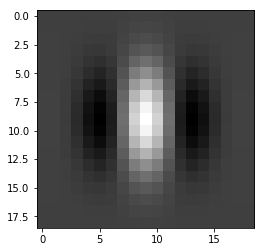

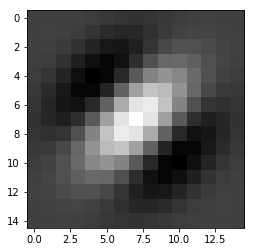

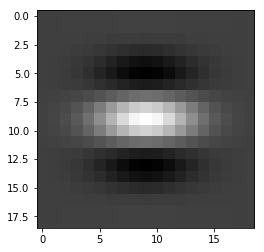

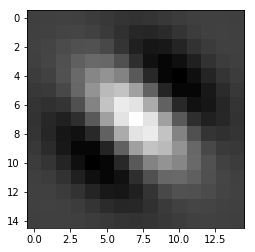

In [42]:
for n in bank2:
    plt.imshow(n, cmap="gray")
    plt.show()

In [12]:
image_dir = "C:/Users/4ja/data/neighborhood_mapping/imagery_orig/sifttest"
image_name = "C:/Users/4ja/data/neighborhood_mapping/imagery_orig/sifttest/dakar_e_wv2_05272018_000020000_000015000_00032.tif"
outdir = "C:/Users/4ja/data/neighborhood_mapping/imagery_orig/sifttest/sift_des"

# kps = write_sift_keypoint_desc(image_name, outdir)
# codebook = create_sift_codebook(image_dir, outdir, n_clusters=32, rand_samp_num=10000)
# preds = assign_codeword(image_dir, "C:/Users/4ja/data/neighborhood_mapping/imagery_orig/sifttest/sift_kmeans_codebook.dat")
# create_codeword_id_image(image_name, image_dir, "C:/Users/4ja/data/neighborhood_mapping/imagery_orig/sifttest/dakar_e_wv2_05272018_000020000_000015000_00032.siftdat")
#o = sift_feature("C:/Users/4ja/data/neighborhood_mapping/imagery_orig/sifttest/sift_codewords.tif", 50, 300, outdir + "/siftim300.tif")
create_sift_codeword_images([image_dir], outdir, n_clusters=32, rand_samp_num=1000)

C:\Users\4ja\AppData\Local\Continuum\miniconda3_64bit\envs\py36\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [ ]:
dat = np.fromfile("C:/Users/4ja/data/neighborhood_mapping/imagery_orig/sifttest/dakar_e_wv2_05272018_000020000_000015000_00032_00000_00000.siftdat").reshape(-1,132)

In [ ]:
pr = assign_codeword("D:/imagery/naip/m_3712221_se_10_h_20160625", "D:/imagery/naip/m_3712221_se_10_h_20160625/sift_kmeans_codebook.dat")